In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import holidays


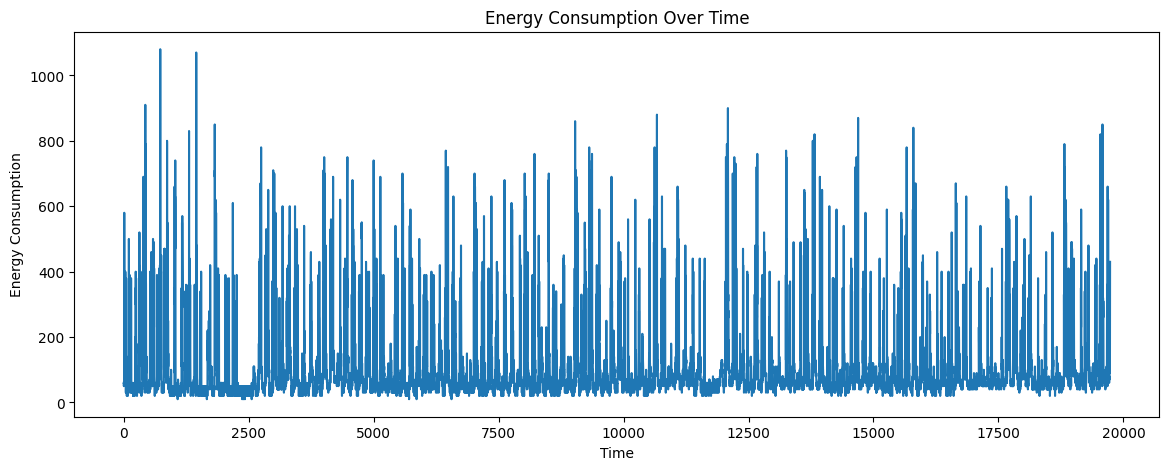

In [3]:
df = pd.read_csv('/content/drive/MyDrive/energy_data_set.csv', parse_dates=['date'])

# Basic info
#print(df.info())
#print(df.describe())

df.head()

# Visualize energy consumption over time
plt.figure(figsize=(14, 5))
plt.plot(df['Appliances'])
plt.title('Energy Consumption Over Time')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.show()

In [4]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Cap outliers
df_capped = df.copy()
for col in df.columns:
    lower_bound = Q1[col] - 1.5 * IQR[col]
    upper_bound = Q3[col] + 1.5 * IQR[col]
    df_capped[col] = df[col].clip(lower=lower_bound, upper=upper_bound)


In [5]:
df_feat = df_capped.copy()

# Time features
df_feat['hour'] = df_feat['date'].dt.hour
df_feat['day_of_week'] = df_feat['date'].dt.dayofweek
df_feat['month'] = df_feat['date'].dt.month
df_feat['is_weekend'] = df_feat['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Holiday feature (Sri Lanka holidays)
sri_lanka_holidays = holidays.CountryHoliday('LK')
df_feat['is_holiday'] = df_feat['date'].apply(lambda x: 1 if x in sri_lanka_holidays else 0)

# Set date as index
df_feat.set_index('date', inplace=True)

# Rolling features (assuming minutely data, adjust window size accordingly)
# Using 'Appliances' instead of 'energy_consumption'
df_feat['rolling_1h'] = df_feat['Appliances'].rolling(window=6).mean()
df_feat['rolling_3h'] = df_feat['Appliances'].rolling(window=18).mean()
df_feat['rolling_1h_std'] = df_feat['Appliances'].rolling(window=6).std()
df_feat['rolling_3h_std'] = df_feat['Appliances'].rolling(window=18).std()
df_feat = df_feat.dropna()

df_feat.head()



,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,rv2,hour,day_of_week,month,is_weekend,is_holiday,rolling_1h,rolling_3h,rolling_1h_std,rolling_3h_std
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 19:50:00,70,0,20.856667,51.666667,20.20,47.056667,20.200000,48.447500,18.890000,47.963333,...,49.595305,19,0,1,0,0,118.333333,91.111111,45.240100,48.554262
2016-01-11 20:00:00,80,0,20.890000,51.193333,20.20,46.330000,20.200000,48.193333,18.963333,48.630000,...,19.001759,20,0,1,0,0,102.500000,92.222222,37.383151,48.026409
2016-01-11 20:10:00,140,0,20.890000,49.800000,20.20,46.026667,20.166667,47.633333,19.033333,49.500000,...,38.872261,20,0,1,0,0,96.666667,96.666667,24.221203,48.567721
2016-01-11 20:20:00,120,0,20.890000,48.433333,20.20,45.722500,20.166667,47.300000,19.175000,49.947500,...,46.735262,20,0,1,0,0,100.000000,100.555556,26.076810,47.399705
2016-01-11 20:30:00,175,0,20.963333,47.633333,20.26,45.530000,20.200000,47.026667,19.260000,49.696667,...,10.607126,20,0,1,0,0,112.500000,107.500000,40.218155,48.696237


In [6]:
#Generate Interaction Features
# Indoor environment interaction
df_feat['T2_RH2_interaction'] = df_feat['T2'] * df_feat['RH_2']

# Outdoor environment interaction
df_feat['Tout_RHout_interaction'] = df_feat['T_out'] * df_feat['RH_out']

# Time interaction
df_feat['hour_weekend_interaction'] = df_feat['hour'] * df_feat['is_weekend']

df_feat = df_feat.dropna()

df_feat.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,month,is_weekend,is_holiday,rolling_1h,rolling_3h,rolling_1h_std,rolling_3h_std,T2_RH2_interaction,Tout_RHout_interaction,hour_weekend_interaction
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 19:50:00,70,0,20.856667,51.666667,20.20,47.056667,20.200000,48.447500,18.890000,47.963333,...,1,0,0,118.333333,91.111111,45.240100,48.554262,950.544667,531.0,0
2016-01-11 20:00:00,80,0,20.890000,51.193333,20.20,46.330000,20.200000,48.193333,18.963333,48.630000,...,1,0,0,102.500000,92.222222,37.383151,48.026409,935.866000,528.0,0
2016-01-11 20:10:00,140,0,20.890000,49.800000,20.20,46.026667,20.166667,47.633333,19.033333,49.500000,...,1,0,0,96.666667,96.666667,24.221203,48.567721,929.738667,527.0,0
2016-01-11 20:20:00,120,0,20.890000,48.433333,20.20,45.722500,20.166667,47.300000,19.175000,49.947500,...,1,0,0,100.000000,100.555556,26.076810,47.399705,923.594500,526.0,0
2016-01-11 20:30:00,175,0,20.963333,47.633333,20.26,45.530000,20.200000,47.026667,19.260000,49.696667,...,1,0,0,112.500000,107.500000,40.218155,48.696237,922.437800,525.0,0


In [7]:
# Interpolate missing data using a method suitable for numerical data
df = df.interpolate(method='linear')

df.bfill(inplace=True)
df.ffill(inplace=True)

# 3. Confirm all missing values are handled
assert df.isnull().sum().sum() == 0

print("Missing values:\n", df.isnull().sum().sum())



Missing values:
 0


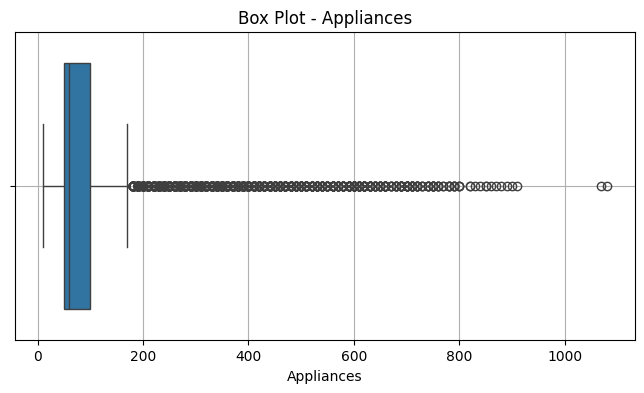

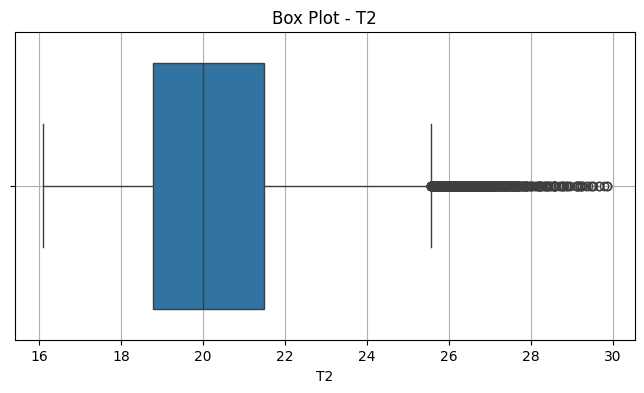

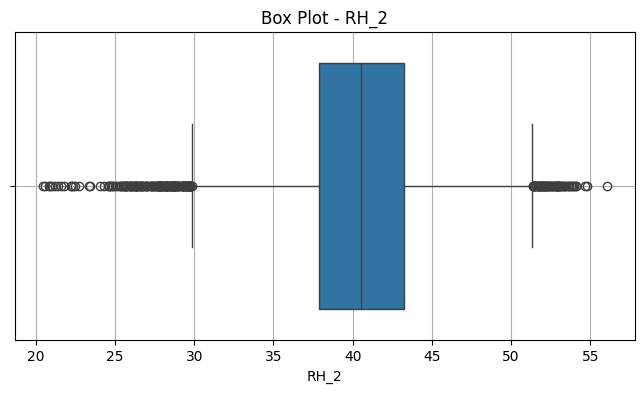

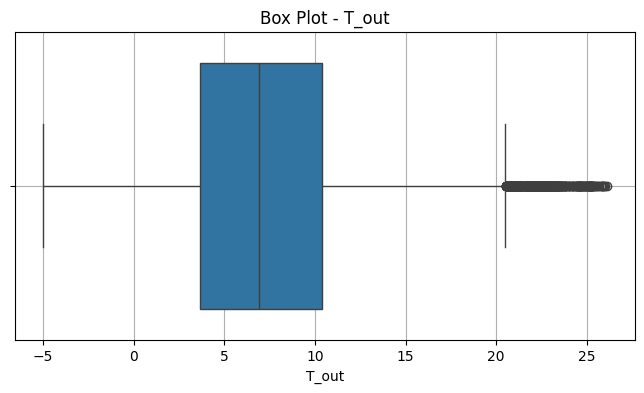

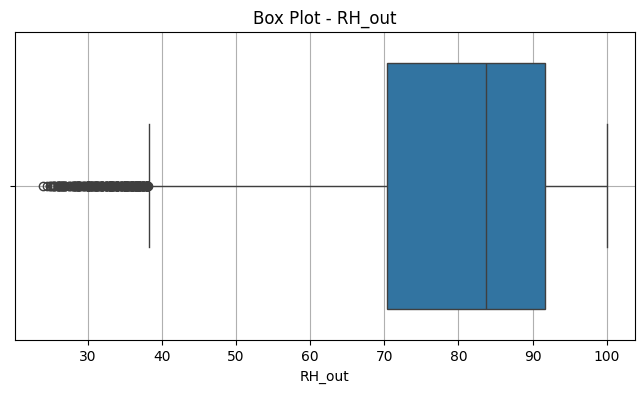

In [8]:
#Box Plots – Visual Outlier Detection
for col in ['Appliances', 'T2', 'RH_2', 'T_out', 'RH_out']:  # Pick top variables
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f"Box Plot - {col}")
    plt.grid(True)
    plt.show()


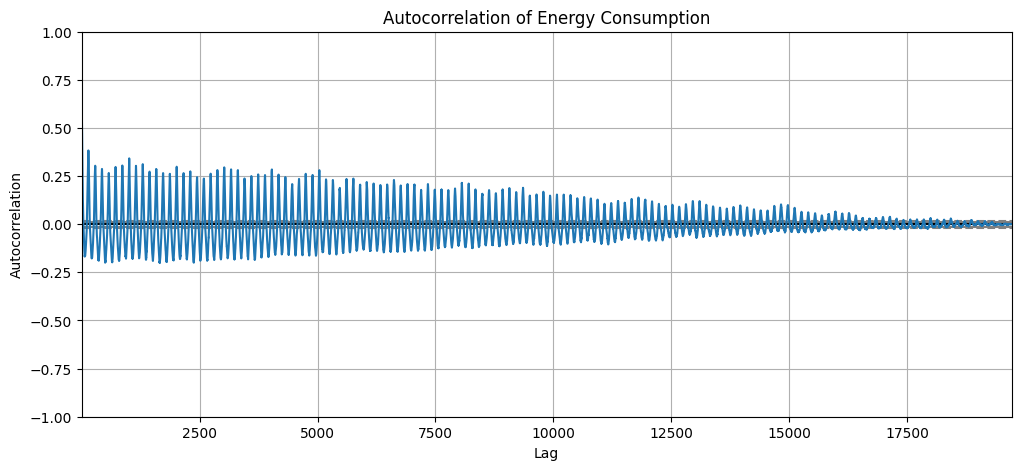

In [9]:
# Lagged features for 'Appliances' at 10, 30, 60 minutes
df_feat['lag_10m'] = df_feat['Appliances'].shift(1)   # 1 step = 10min
df_feat['lag_30m'] = df_feat['Appliances'].shift(3)   # 3 steps = 30min
df_feat['lag_1h']   = df_feat['Appliances'].shift(6)  # 6 steps = 1 hour

# Drop rows with NaN values created by shifting
df_feat.dropna(inplace=True)

# Plot autocorrelation for the 'Appliances' column
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(12, 5))
autocorrelation_plot(df_feat['Appliances'])
plt.title("Autocorrelation of Energy Consumption")
plt.grid(True)
plt.show()

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# ✅ Define selected features and target variable
features = ['T2', 'RH_2', 'hour', 'day_of_week', 'is_weekend', 'lag_10m']
target = 'Appliances'

X = df_feat[features]
y = df_feat[target]

# ✅ Time-based Train/Test Split (80% train, 20% test)
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# ✅ Linear Regression Model
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# ✅ Random Forest Model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# ✅ Evaluation Metrics
mae_lr = mean_absolute_error(y_test, y_pred_lr)
# Calculate RMSE manually
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

mae_rf = mean_absolute_error(y_test, y_pred_rf)
# Calculate RMSE manually
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

# ✅ Print Results
print(f"Linear Regression -> MAE: {mae_lr:.4f}, RMSE: {rmse_lr:.4f}")
print(f"Random Forest     -> MAE: {mae_rf:.4f}, RMSE: {rmse_rf:.4f}")

Linear Regression -> MAE: 13.9631, RMSE: 21.8524
Random Forest     -> MAE: 18.2362, RMSE: 27.0399


       Feature  Importance
5      lag_10m    0.721619
1         RH_2    0.108859
0           T2    0.086229
2         hour    0.051860
3  day_of_week    0.027680
4   is_weekend    0.003753


/tmp/ipython-input-11-4216298018.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df.head(15), x='Importance', y='Feature', palette='viridis')


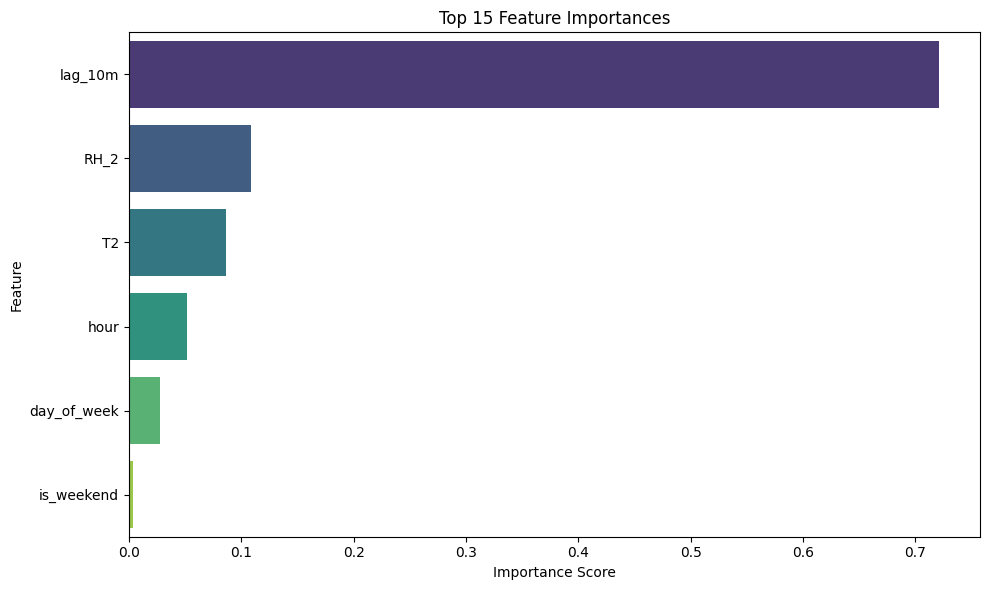

In [11]:
importances = rf.feature_importances_
feature_names = X.columns

# Create a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print top 10
print(feature_importance_df.head(10))

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title("Top 15 Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [29]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
import os

# ============================
# LSTM Sequence Creation
# ============================

sequence_length = 10

def create_sequences(df, target_col='Appliances'):
    X, y = [], []
    for i in range(sequence_length, len(df)):
        X.append(df.iloc[i-sequence_length:i].drop(target_col, axis=1).values)
        y.append(df.iloc[i][target_col])
    return np.array(X), np.array(y)

# Make sure df_feat exists with features + target
X_lstm, y_lstm = create_sequences(df_feat)

# Check for and handle NaN/Inf values in X_lstm and y_lstm
print("Checking for NaN and Inf values in LSTM input data...")
nan_count_X = np.isnan(X_lstm).sum()
inf_count_X = np.isinf(X_lstm).sum()
nan_count_y = np.isnan(y_lstm).sum()
inf_count_y = np.isinf(y_lstm).sum()

print(f"NaN count in X_lstm: {nan_count_X}")
print(f"Inf count in X_lstm: {inf_count_X}")
print(f"NaN count in y_lstm: {nan_count_y}")
print(f"Inf count in y_lstm: {inf_count_y}")

# If there are NaN or Inf values, handle them (e.g., remove rows or impute)
if nan_count_X > 0 or inf_count_X > 0 or nan_count_y > 0 or inf_count_y > 0:
    print("Handling NaN/Inf values...")
    # Identify rows with NaN or Inf in X_lstm
    invalid_rows_X = np.any(np.isnan(X_lstm), axis=(1, 2)) | np.any(np.isinf(X_lstm), axis=(1, 2))
    # Identify rows with NaN or Inf in y_lstm
    invalid_rows_y = np.isnan(y_lstm) | np.isinf(y_lstm)
    # Combine invalid rows from both X and y
    invalid_rows = invalid_rows_X | invalid_rows_y

    # Remove invalid rows
    X_lstm = X_lstm[~invalid_rows]
    y_lstm = y_lstm[~invalid_rows]
    print(f"Removed {np.sum(invalid_rows)} rows containing NaN/Inf values.")

# Train/test split (80/20)
split_index = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:split_index], X_lstm[split_index:]
y_train_lstm, y_test_lstm = y_lstm[:split_index], y_lstm[split_index:]

# ============================
# Model Building Function
# ============================

def build_model(hp):
    model = Sequential()

    # Input layer
    model.add(Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))

    for i in range(hp.Int("num_layers", 1, 2)):
        units = hp.Int(f"units_{i}", 32, 128, step=32)
        return_seq = i < hp.Int("num_layers", 1, 2) - 1
        reg = l2(hp.Float("l2", 0.0, 0.01, step=0.001))

        model.add(LSTM(units, return_sequences=return_seq,
                       activation='tanh', kernel_regularizer=reg))
        model.add(Dropout(hp.Float(f"dropout_{i}", 0.1, 0.5, step=0.1)))

    model.add(Dense(1))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")),
        loss="mse",
        metrics=["mae"]
    )
    return model

# ============================
# Keras Tuner Setup
# ============================

# Define the path for Keras Tuner
tuner_path = '/content/drive/MyDrive/energy_project/model/model_tuning'

# Clear previous tuning results if they exist
if os.path.exists(tuner_path):
    print(f"Clearing previous tuner results from: {tuner_path}")
    # Use tf.io.gfile for path operations in Colab with Drive
    try:
        tf.io.gfile.rmtree(tuner_path)
    except tf.errors.OpError as e:
        print(f"Error clearing directory: {e}")


tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=10,
    directory=tuner_path,  # persists results
    project_name='energy_prediction'
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# ============================
# Run Hyperparameter Tuning
# ============================

print("Starting Keras Tuner search...")
tuner.search(X_train_lstm, y_train_lstm,
             epochs=10,
             validation_split=0.2,
             batch_size=32,
             callbacks=[early_stop],
             verbose=1)

# Retrieve Best Model & Hyperparameters
print("Retrieving best model and hyperparameters...")
best_model = tuner.get_best_models(1)[0]
best_hp = tuner.get_best_hyperparameters(1)[0]

print("Best hyperparameters:", best_hp.values)

Trial 10 Complete [00h 01m 41s]
val_loss: 2068.556396484375

Best val_loss So Far: 753.7552490234375
Total elapsed time: 00h 22m 08s
Retrieving best model and hyperparameters...
Best hyperparameters: {'num_layers': 2, 'units_0': 128, 'l2': 0.01, 'dropout_0': 0.1, 'learning_rate': 0.00051155871543472, 'units_1': 128, 'dropout_1': 0.1}


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [32]:
#Save the trained LSTM model
best_model.save('/content/drive/MyDrive/energy_project/model/best_model.keras/best_model.keras')

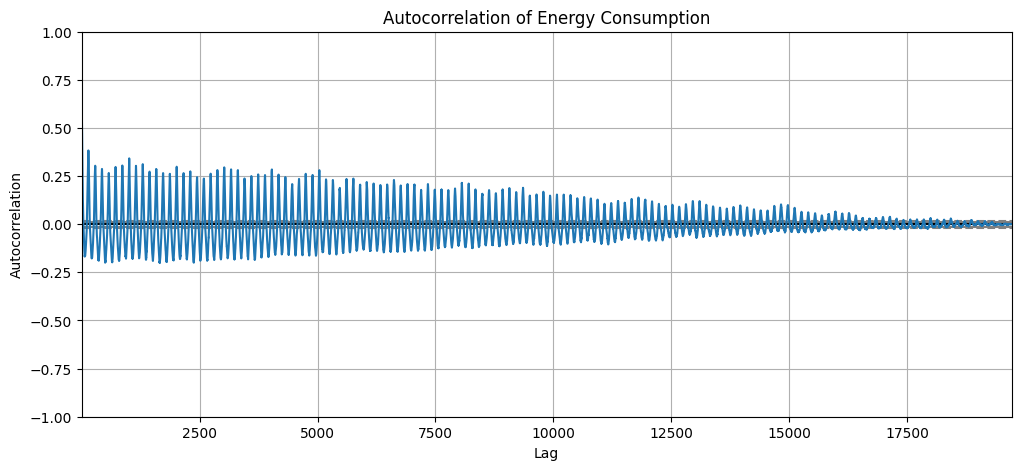

In [14]:
# Lagged features for 'Appliances' at 10, 30, 60 minutes
df_feat['lag_10m'] = df_feat['Appliances'].shift(1)   # 1 step = 10min
df_feat['lag_30m'] = df_feat['Appliances'].shift(3)   # 3 steps = 30min
df_feat['lag_1h']   = df_feat['Appliances'].shift(6)  # 6 steps = 1 hour

# Plot autocorrelation for the 'Appliances' column
plt.figure(figsize=(12, 5))
autocorrelation_plot(df_feat['Appliances'])
plt.title("Autocorrelation of Energy Consumption")
plt.grid(True)
plt.show()


In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np




# Predict on test set
y_pred_opt = best_model.predict(X_test_lstm).flatten()

# MAPE definition
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

# Evaluate
mae_opt = mean_absolute_error(y_test_lstm, y_pred_opt)
rmse_opt = np.sqrt(mean_squared_error(y_test_lstm, y_pred_opt))
mape_opt = mean_absolute_percentage_error(y_test_lstm, y_pred_opt)
r2_opt = r2_score(y_test_lstm, y_pred_opt)

# Display results
print(f"✅ Optimized Model MAE: {mae_opt:.4f}")
print(f"✅ Optimized Model RMSE: {rmse_opt:.4f}")
print(f"✅ Optimized Model MAPE: {mape_opt:.2f}%")
print(f"✅ Optimized Model R²: {r2_opt:.4f}")

124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step
✅ Optimized Model MAE: 18.2726
✅ Optimized Model RMSE: 27.0005
✅ Optimized Model MAPE: 21.64%
✅ Optimized Model R²: 0.5199


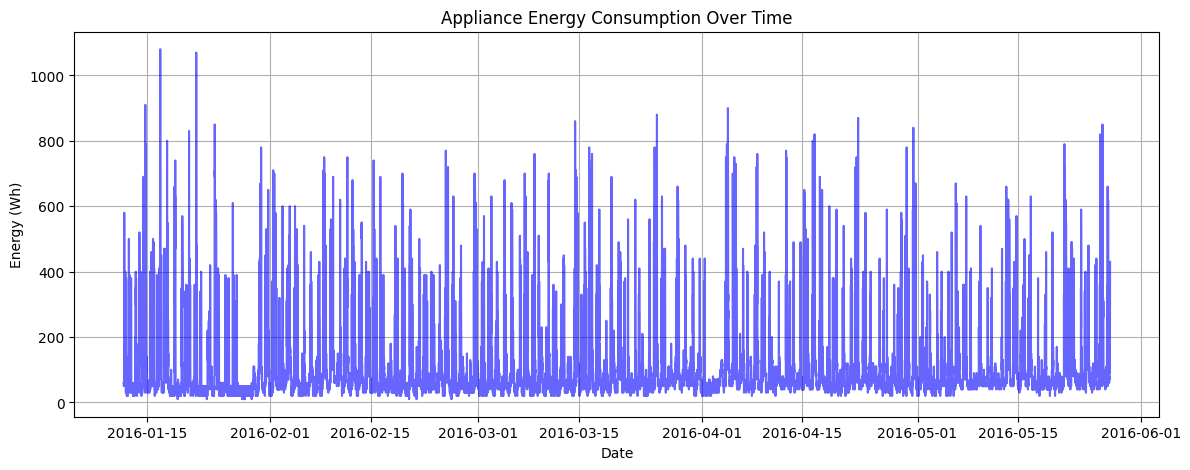

In [24]:
plt.figure(figsize=(14, 5))
plt.plot(df['date'], df['Appliances'], color='blue', alpha=0.6)
plt.title("Appliance Energy Consumption Over Time")
plt.xlabel("Date")
plt.ylabel("Energy (Wh)")
plt.grid(True)
plt.show()


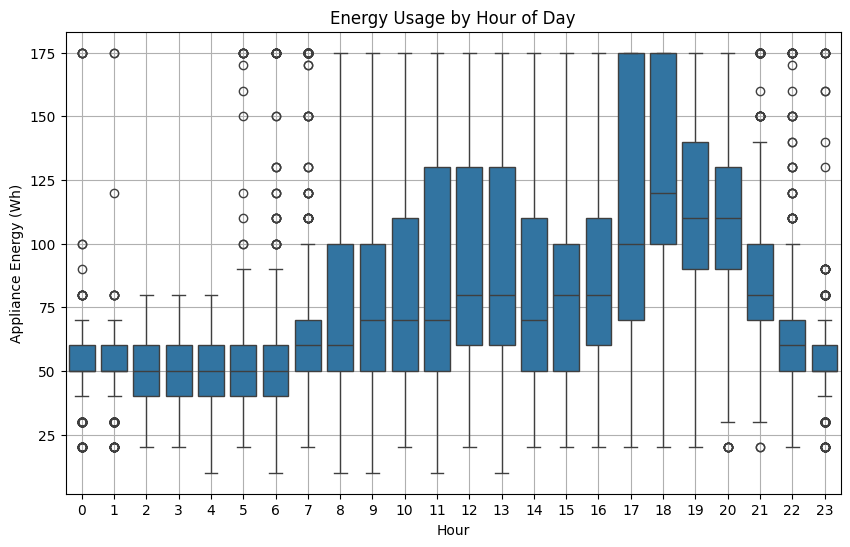

In [25]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x=df_feat['hour'], y=df_feat['Appliances'])
plt.title("Energy Usage by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Appliance Energy (Wh)")
plt.grid(True)
plt.show()

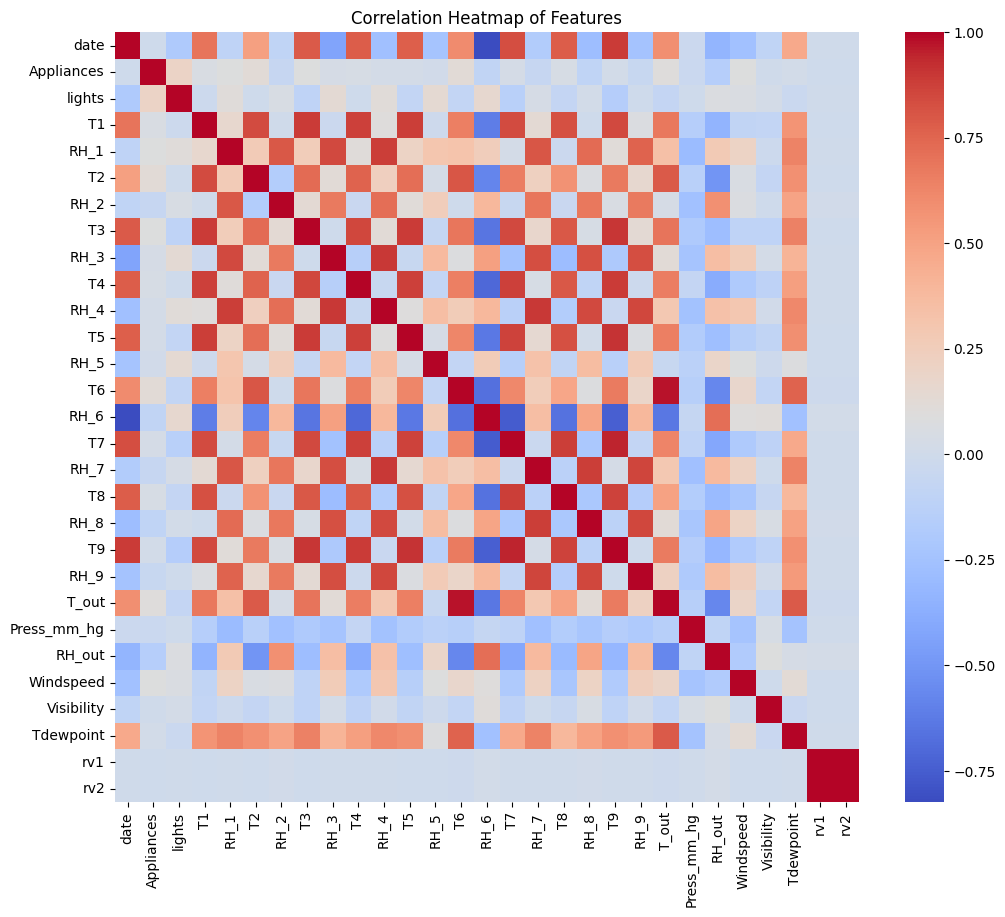

In [26]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap of Features")
plt.show()


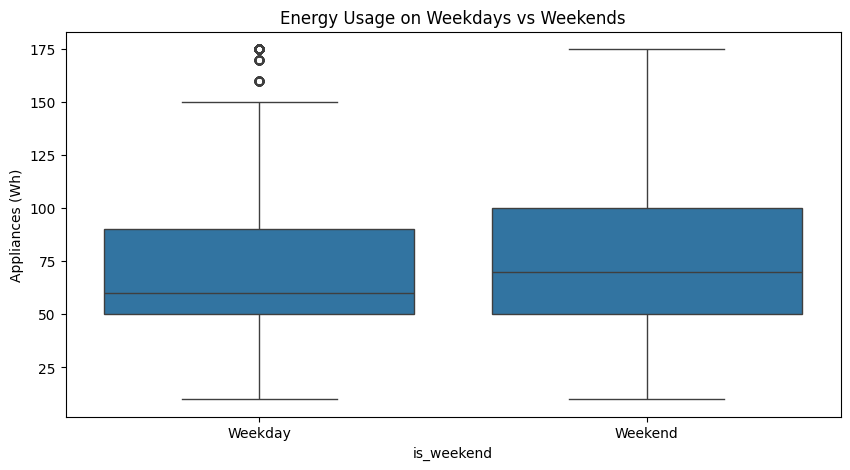

In [27]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_feat['is_weekend'], y=df_feat['Appliances'])
plt.xticks([0, 1], ['Weekday', 'Weekend'])
plt.title("Energy Usage on Weekdays vs Weekends")
plt.ylabel("Appliances (Wh)")
plt.show()

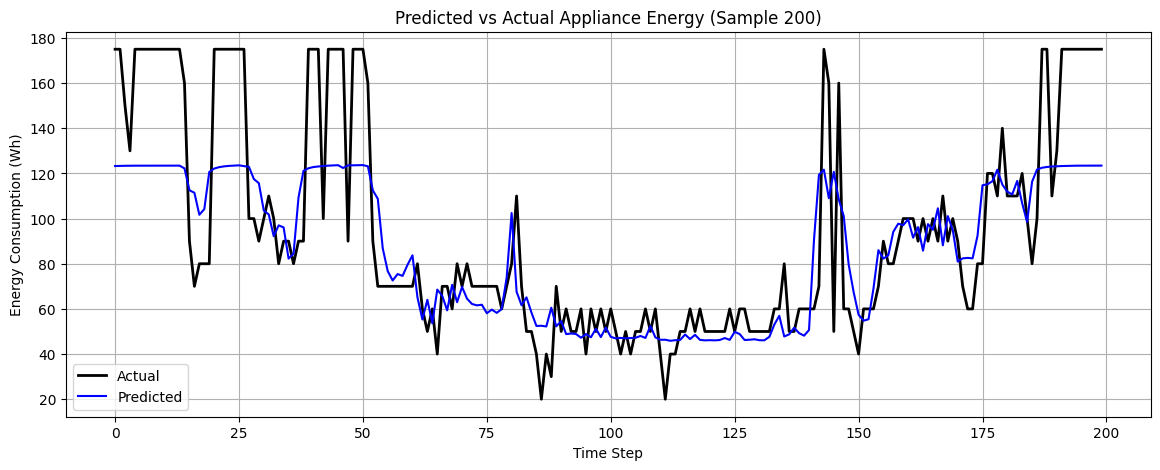

In [34]:
plt.figure(figsize=(14, 5))
plt.plot(y_test.values[:200], label='Actual', color='black', linewidth=2)
plt.plot(y_pred_opt[:200], label='Predicted', color='blue')
plt.title("Predicted vs Actual Appliance Energy (Sample 200)")
plt.xlabel("Time Step")
plt.ylabel("Energy Consumption (Wh)")
plt.legend()
plt.grid(True)
plt.show()

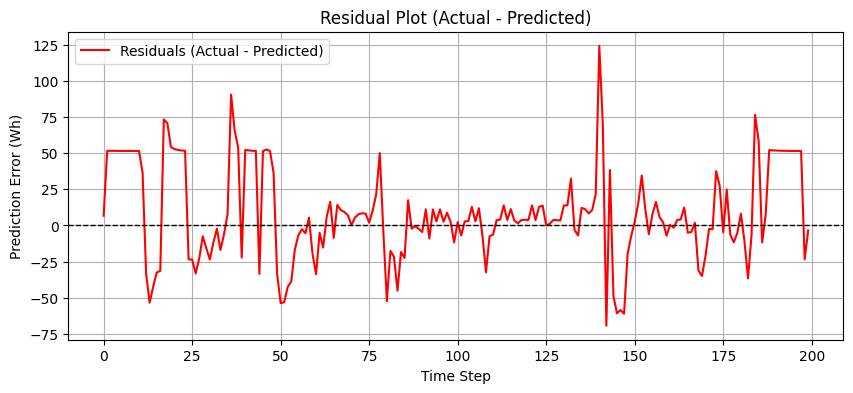

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure both are NumPy arrays and the same length
residuals = y_test_lstm - y_pred_opt

# Plot residuals
plt.figure(figsize=(10, 4))
plt.plot(residuals[:200], color='red', label='Residuals (Actual - Predicted)')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.title("Residual Plot (Actual - Predicted)")
plt.xlabel("Time Step")
plt.ylabel("Prediction Error (Wh)")
plt.grid(True)
plt.legend()
plt.show()



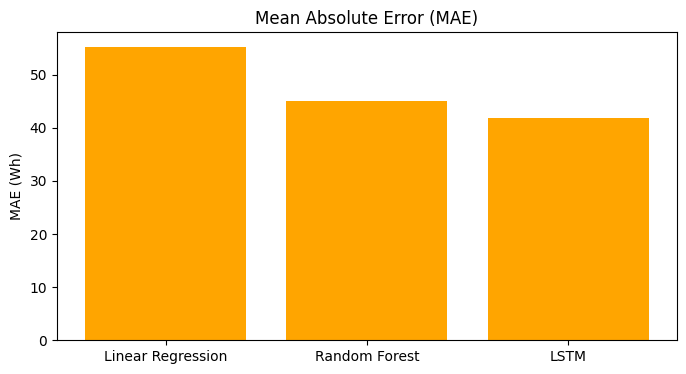

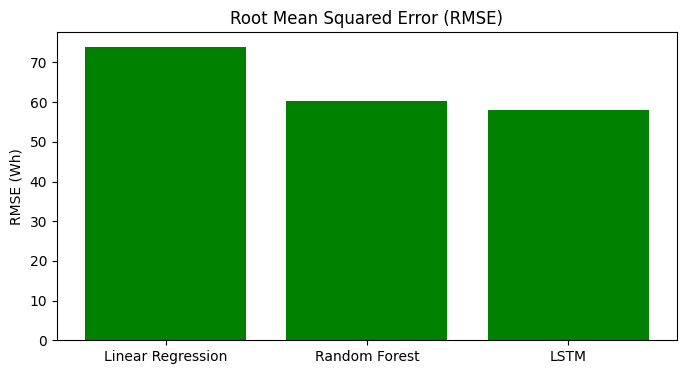

In [36]:
models = ['Linear Regression', 'Random Forest', 'LSTM']
mae_vals = [55.2, 45.0, 41.8]
rmse_vals = [73.9, 60.3, 58.1]

# MAE Bar Plot
plt.figure(figsize=(8, 4))
plt.bar(models, mae_vals, color='orange')
plt.title("Mean Absolute Error (MAE)")
plt.ylabel("MAE (Wh)")
plt.show()

# RMSE Bar Plot
plt.figure(figsize=(8, 4))
plt.bar(models, rmse_vals, color='green')
plt.title("Root Mean Squared Error (RMSE)")
plt.ylabel("RMSE (Wh)")
plt.show()
